# Learning with backprop and generalisation in multi-layer perceptron

This exercise is concerned with supervised learning approaches for feed-forward multilayer networks - MLP (MLPs)



## Classification and regression with a two-layer perceptron

### Classification of linearly non-separable data


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.colors as clr


# Sigmoid function with range [-1, 1]
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1


# Gives the derivative of the sigmoid function
def sigmoid_derivative(x):
    return 0.5 * ((1 + sigmoid(x)) * (1 - sigmoid(x)))


# Forward propagation
def forward(X, first_layer, hidden_layer):
    # Output first layer
    WX = first_layer.dot(X)
    H = sigmoid(WX)
    # Output second layer
    H = np.vstack([H, np.ones(np.shape(H)[1])])  # Add bias
    VH = hidden_layer.dot(H)
    # Predicted output
    O = sigmoid(VH)
    return O, H


# Backward propagation --> Just check how the error changes w.r.t the weights
def backward(T, O, H, V, Nhidden):
    # Delta error output layer
    delta_o = (O - T) * (sigmoid_derivative(O))
    # Delta error hidden layer
    delta_h = np.dot(V.T, delta_o) * (sigmoid_derivative(H))
    # Remove bias
    delta_h = delta_h[0:Nhidden]
    return delta_o, delta_h


# Update the weights
def weightUpdate(delta_o, delta_h, X, H, W, V, eta, dw, dv, alpha):
    # Dw = momentum * dw - (1 - momentum) * (delta_h.dot(X.T))
    dw = alpha * dw - (1 - alpha) * (delta_h.dot(X.T))
    # Update the weights
    W = W + eta * dw
    V = V + eta * dv
    return W, V, dw, dv


def backpropagation(X, T, W, V, eta, epochs, Nhidden, alpha=0.9):
    errors_list = []
    misclassifications_list = []

    dw = np.ones(np.shape(W))
    dv = np.ones(np.shape(V))

    all_weights1 = []
    all_weights2 = []

    # Loop over the epochs
    for i in range(epochs):
        all_weights1.append(W)
        all_weights2.append(V)
        O, H = forward(X, W, V)

        number_misclassifications = np.shape(X)[1] - np.sum(np.round(O) == T)
        ratio = number_misclassifications / (np.shape(X)[1])

        misclassifications_list.append(ratio)
        errors_list.append(np.mean(np.square(O - T)))
        delta_o, delta_h = backward(T, O, H, V, Nhidden)
        W, V, dw, dv = weightUpdate(delta_o, delta_h, X, H, W, V, eta, dw, dv, alpha)

    all_weights1.append(W)
    all_weights2.append(V)
    return W, V, errors_list, misclassifications_list, all_weights1, all_weights2


# Predict the output
def predict(data, weights, hidden_weights, clasification=True):
    output, _ = forward(data, weights, hidden_weights)
    if clasification:
        output[output >= 1] = 1
        output[output < 0] = -1
    return output


def plot_decision_boundary(patterns, T, points=True, h=0.1):
    # Minimum and maximum values for the two input variables
    x_min, x_max = patterns[0, :].min() - 1, patterns[0, :].max() + 1
    y_min, y_max = patterns[1, :].min() - 1, patterns[1, :].max() + 1

    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    grid_data = np.transpose(np.c_[xx.ravel(), yy.ravel()])
    ones = np.transpose(np.ones((np.shape(xx)[1] * np.shape(xx)[0], 1)))
    grid_data = np.vstack((grid_data, ones))
    Z = predict(grid_data, W, V)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    if points:
        plt.scatter(
            patterns[0, :],
            patterns[1, :],
            c=T,
            cmap=clr.ListedColormap(["red", "green"]),
        )
    plt.show()

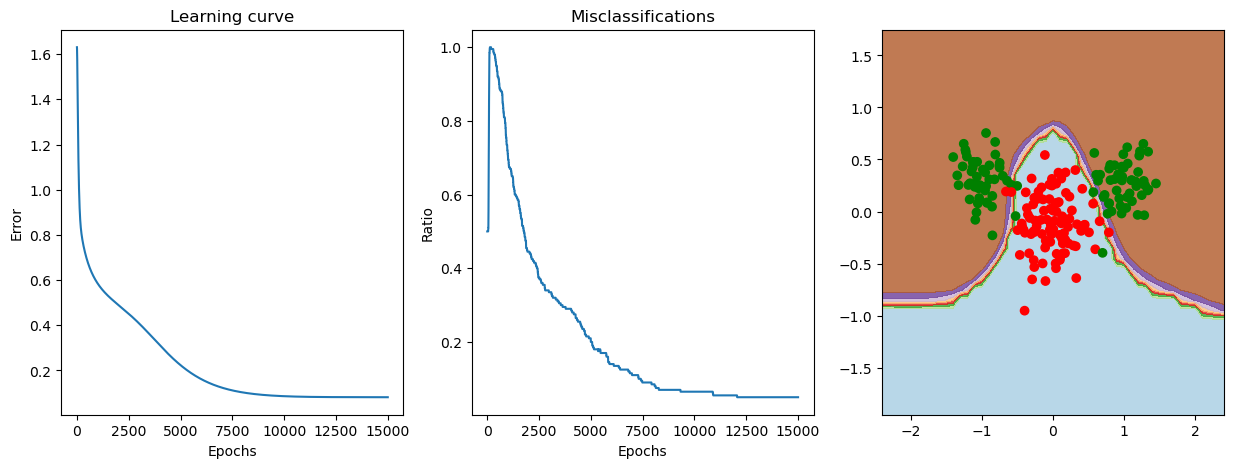

In [18]:
mA = [1, 0.3]
sigmaA = 0.2
mB = [0, -0.1]
sigmaB = 0.3

# Backpropagation parameters
epochs = 15000
eta = 0.0005
Nhidden = 5


# Generate the classes. 2 dimensional with 100 points each
classA = np.zeros((2, 100))
classB = np.zeros((2, 100))

classA[0] = np.concatenate(
    (
        np.random.randn(1, int(0.5 * 100)) * sigmaA - mA[0],
        np.random.randn(1, int(0.5 * 100)) * sigmaA + mA[0],
    ),
    axis=1,
)
classB[0] = np.random.randn(1, 100) * sigmaB + mB[0]
classA[1] = np.random.randn(1, 100) * sigmaA + mA[1]
classB[1] = np.random.randn(1, 100) * sigmaB + mB[1]
classA = classA.T
classB = classB.T
np.random.shuffle(classA)
np.random.shuffle(classB)
classA = classA.T
classB = classB.T

# Creating the dataset
dataset = np.concatenate((classA, classB), axis=1)
dataset = np.concatenate((dataset, np.ones((1, np.shape(dataset)[1]))))
targets = np.concatenate((np.ones(np.shape(classA)[1]), -np.ones(np.shape(classB)[1])))
s = np.arange(dataset.shape[1])

# SHuffle the dataset
np.random.shuffle(s)
patterns = dataset[:, s]
targets = targets[s]

# Initialize the weights
weights1 = np.random.randn(Nhidden, np.shape(patterns)[0])
weights2 = np.random.randn(1, Nhidden + 1)

(
    W,
    V,
    errors_list,
    misclassifications_list,
    all_weights1,
    all_weights2,
) = backpropagation(
    patterns, targets, weights1, weights2, eta, epochs, Nhidden, alpha=0.9
)

# Create 1 x 3 subplots. One with the learning curve and one with decision boundary and one with missclassifications
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(errors_list)
axs[0].set_title("Learning curve")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Error")

axs[1].plot(misclassifications_list)
axs[1].set_title("Misclassifications")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Ratio")

axs[2].plot = plot_decision_boundary(patterns, targets, points=True)
axs[2].set_title("Decision boundary")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()




### Question 1: 
Modify the number of hidden nodes and demonstrate the effect the size
of the hidden layer has on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?

**Answer**
A low ETA is good as it prevents overshooting. If we add more hidden nodes then less inputs will be missclassifed HOWEVER this could be due to overfitting. More nodes = More complex = More higher accuracy however if we were to try with validation set then it would be less accurate.

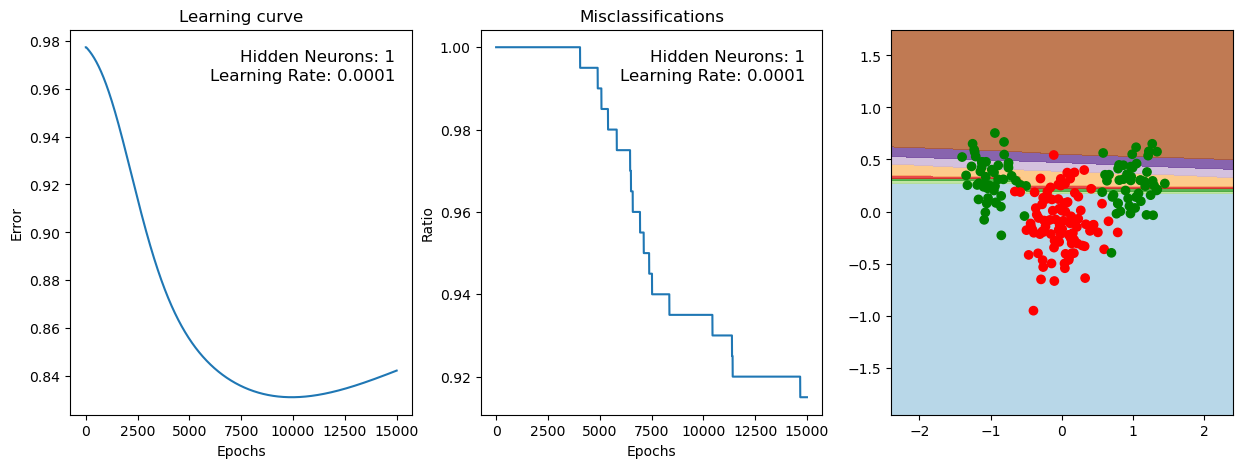

C:\Users\rakin\AppData\Local\Temp\ipykernel_6076\954886398.py:9: RuntimeWarning: overflow encountered in exp
  return 2 / (1 + np.exp(-x)) - 1


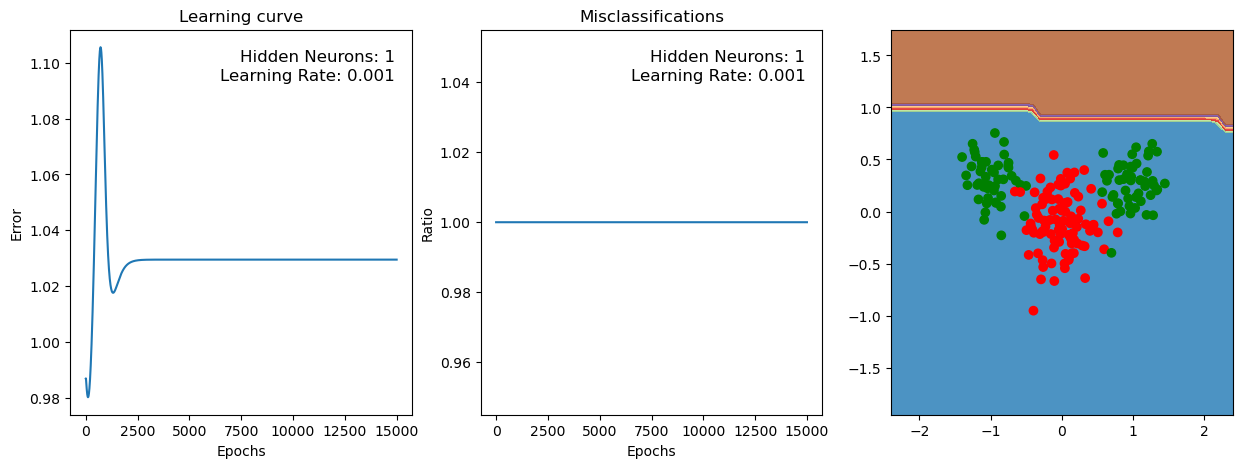

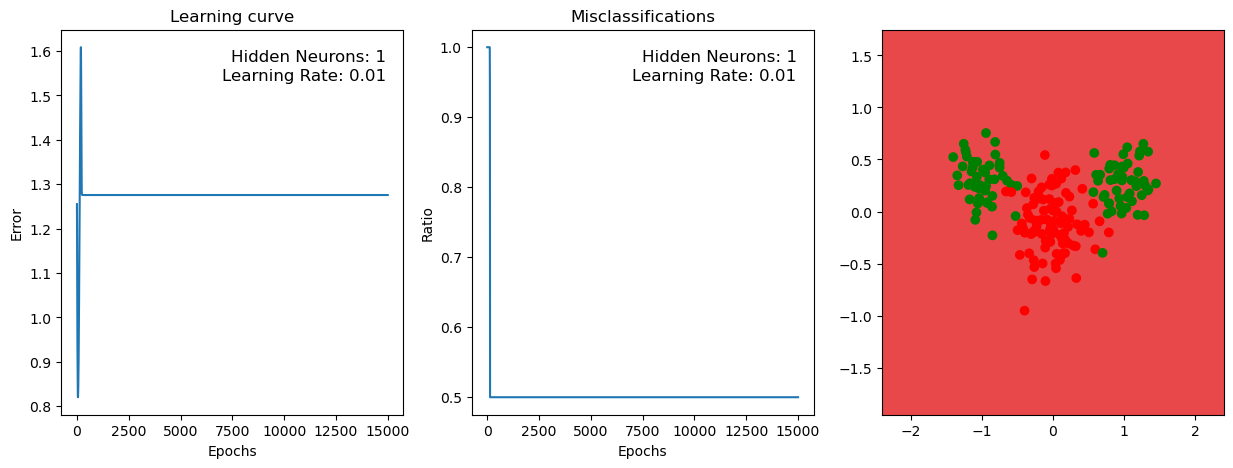

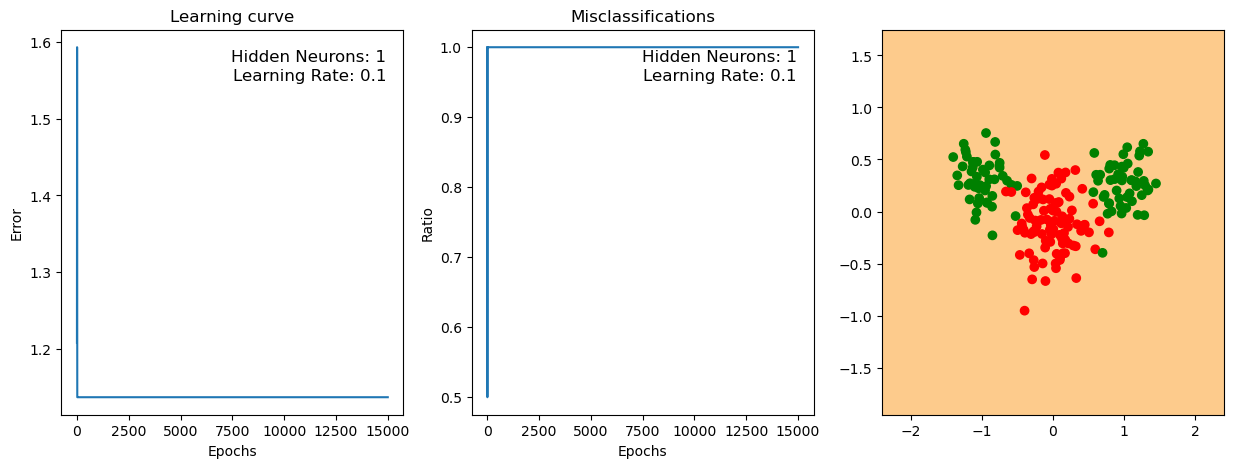

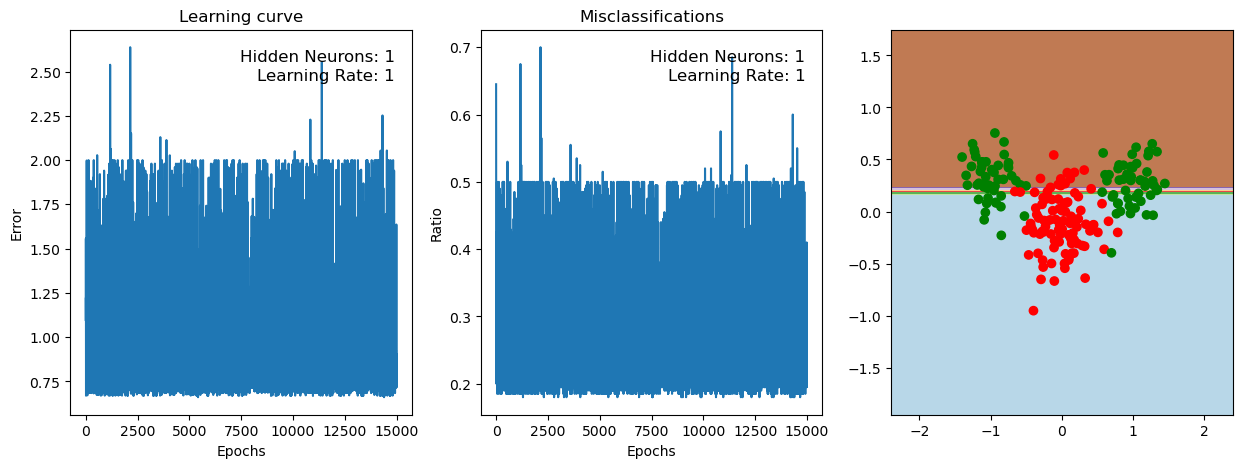

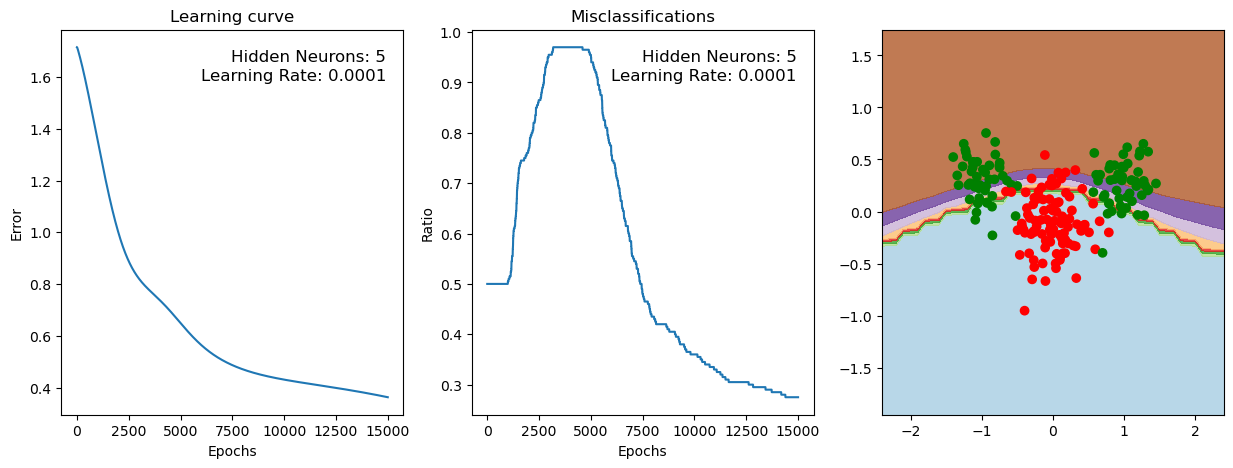

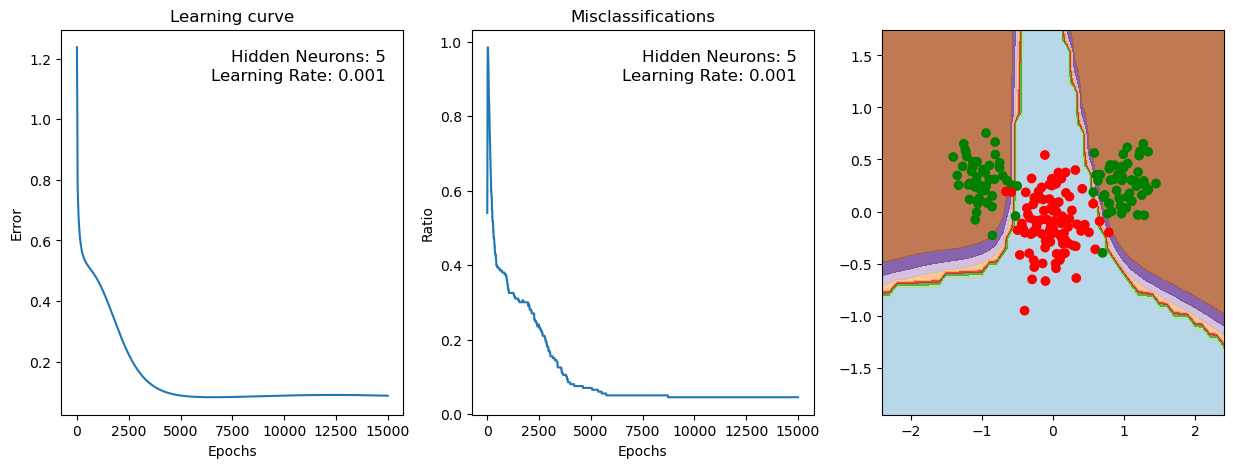

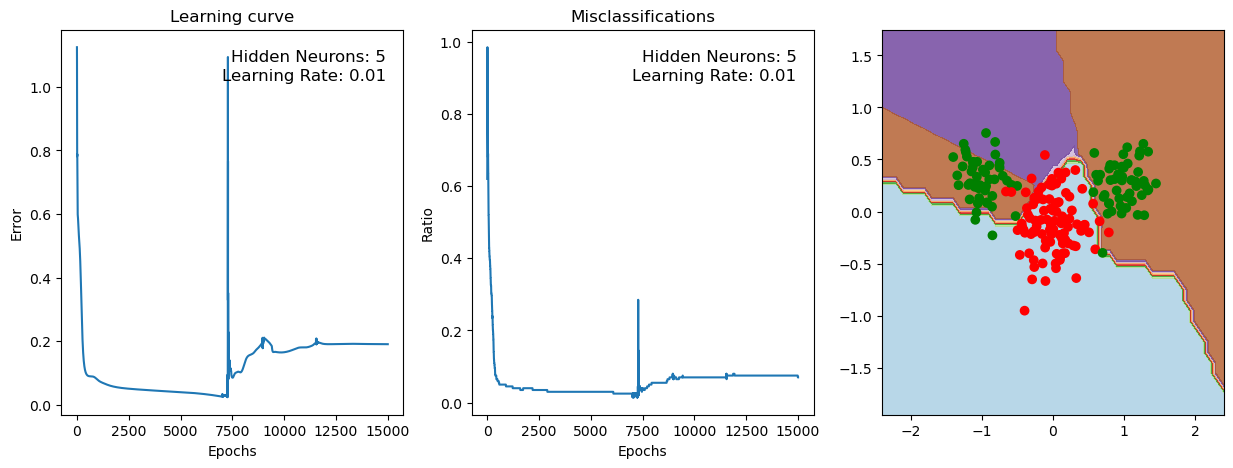

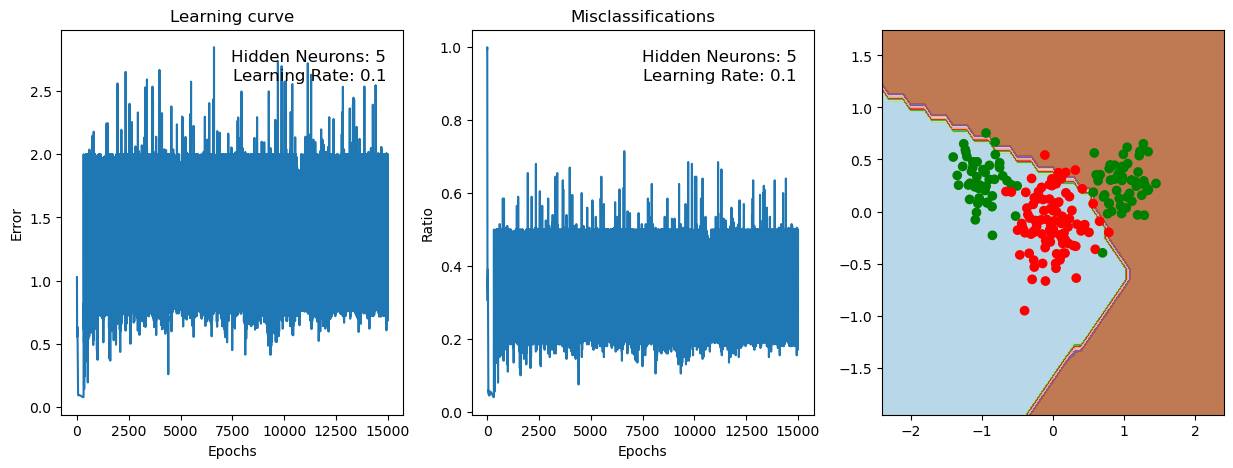

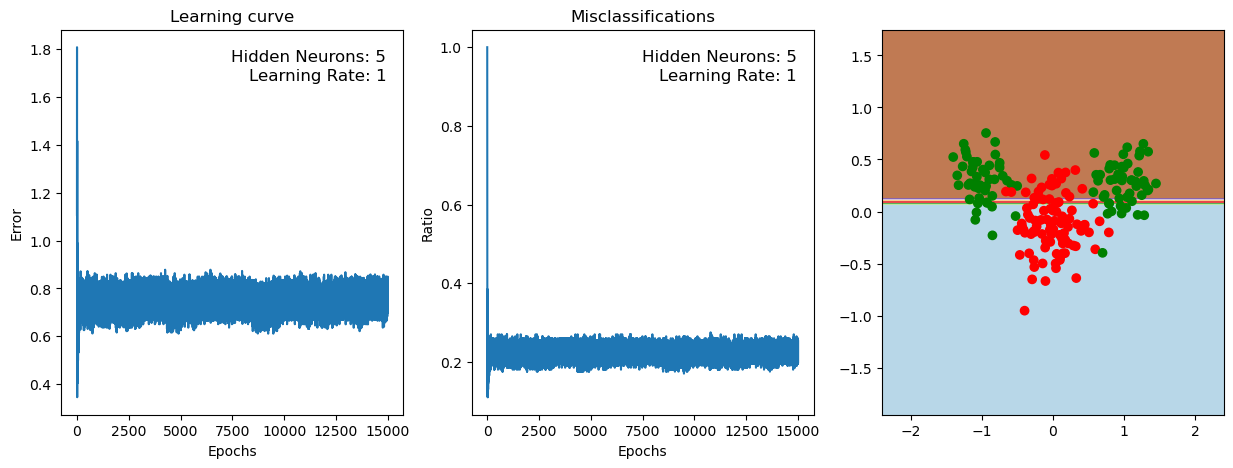

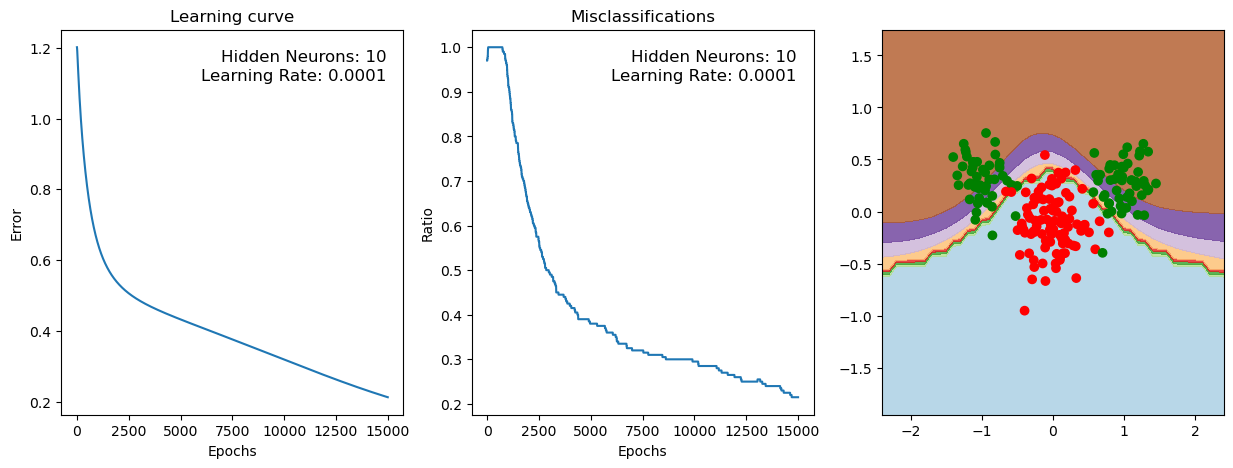

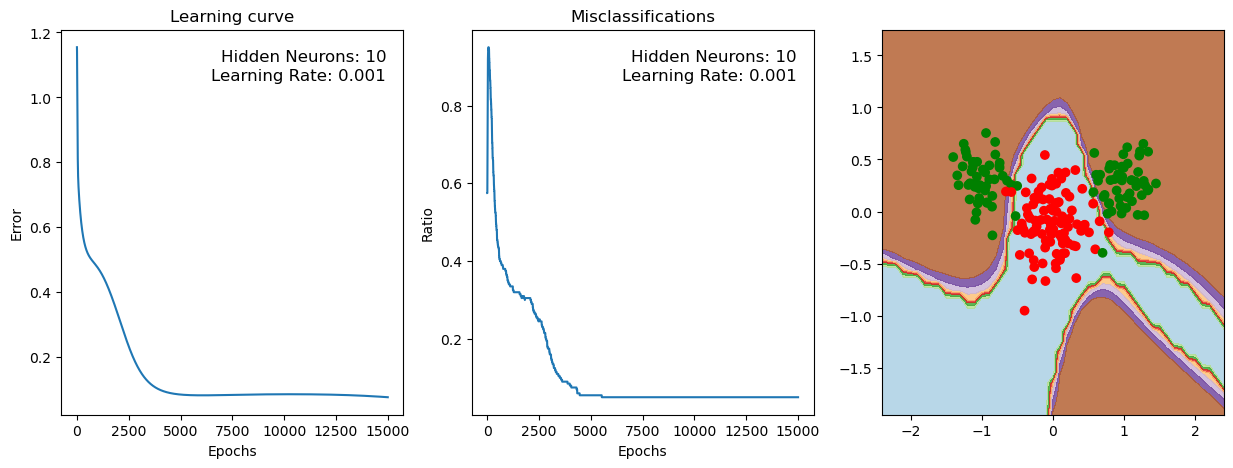

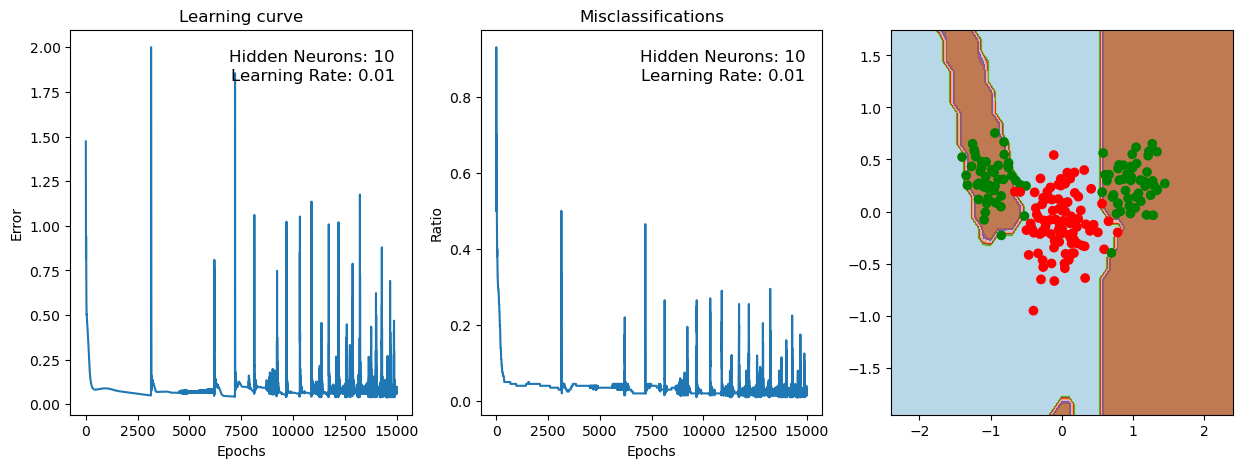

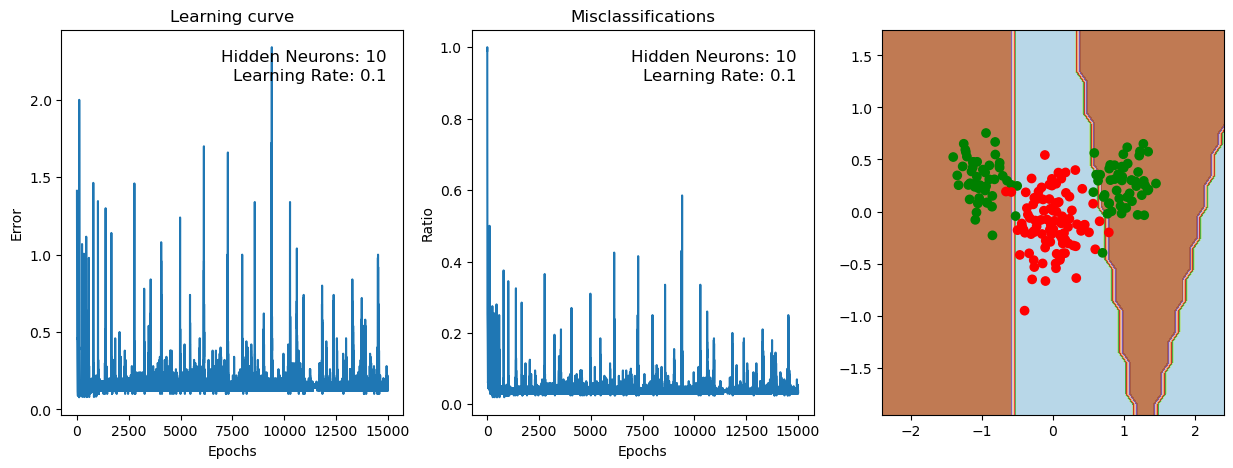

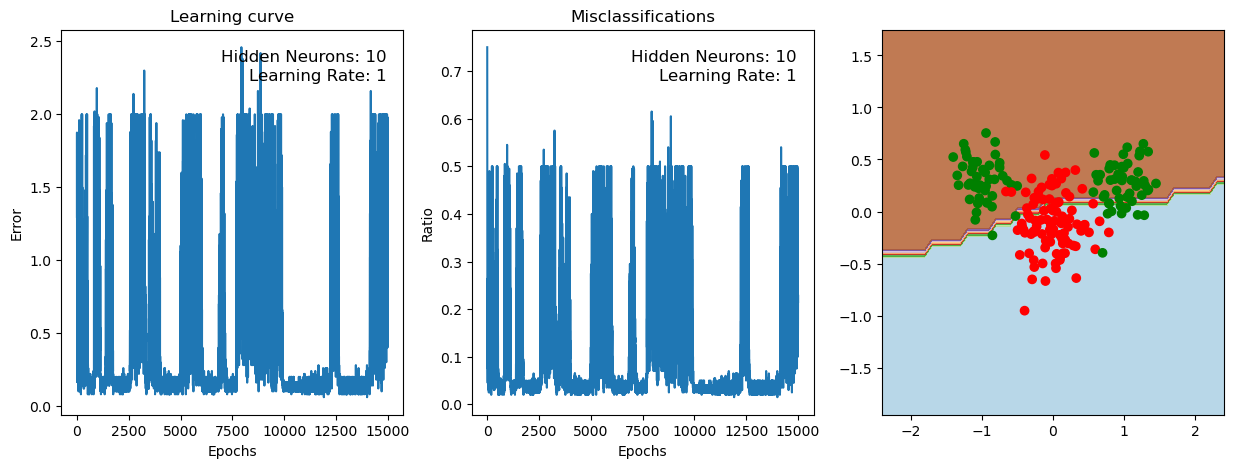

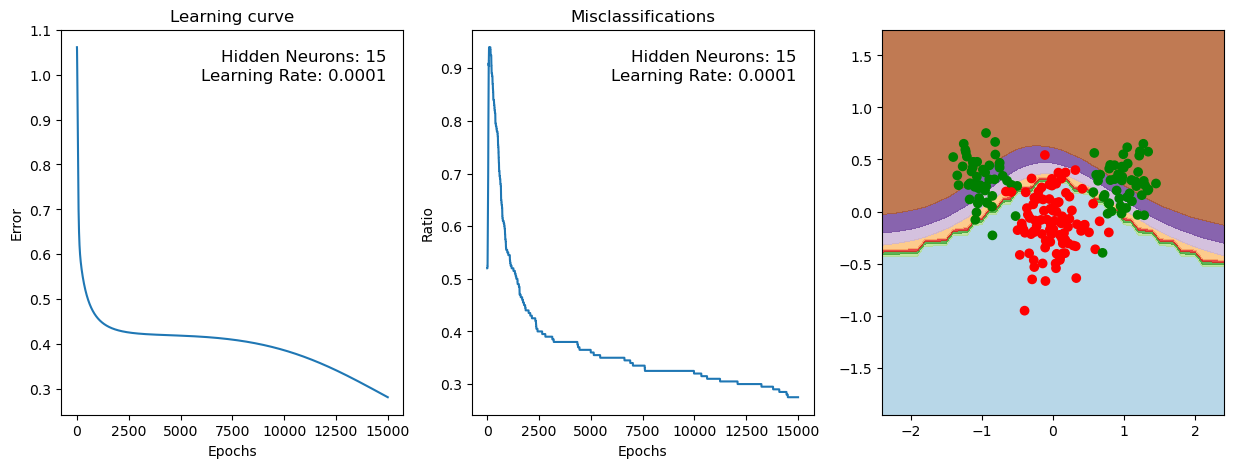

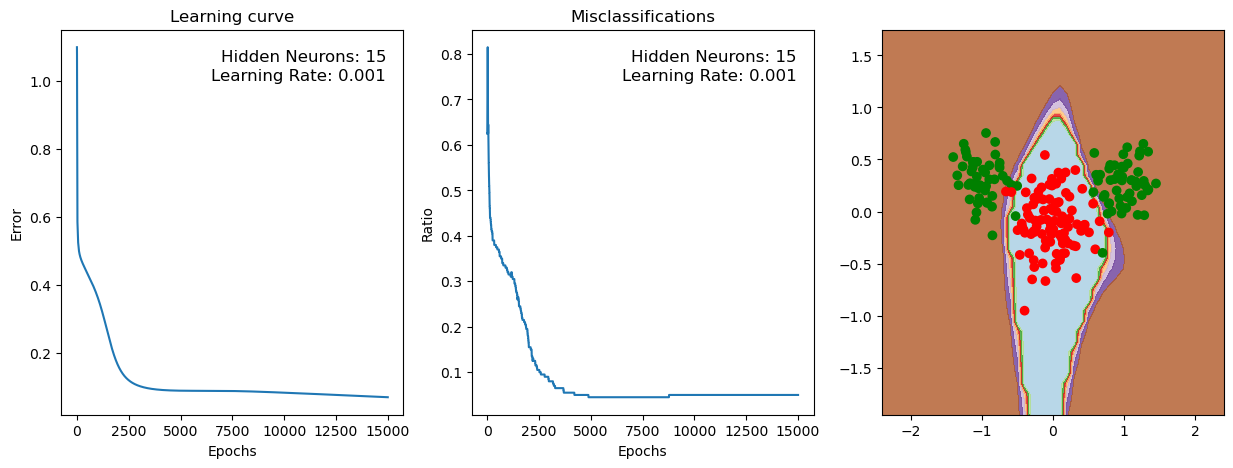

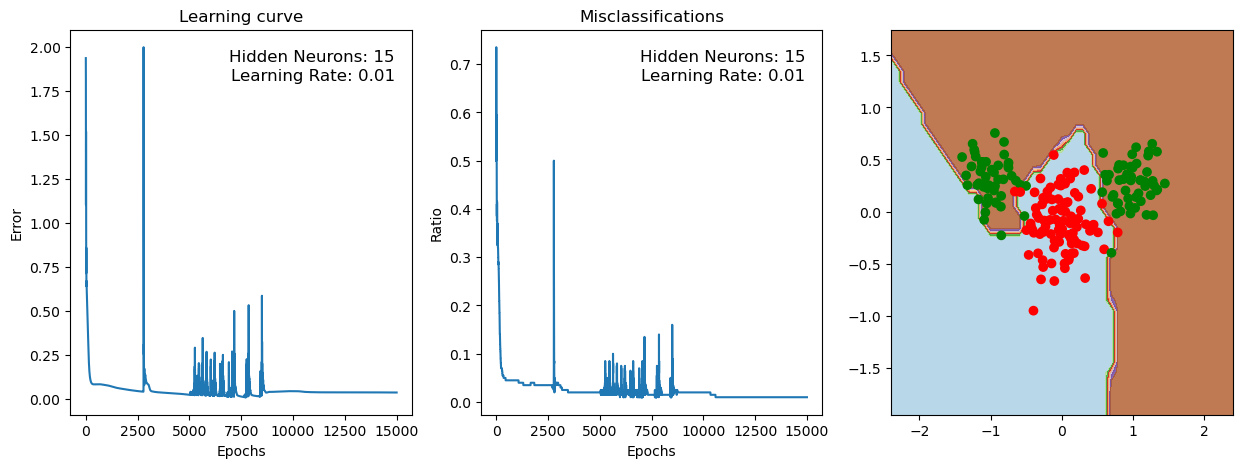

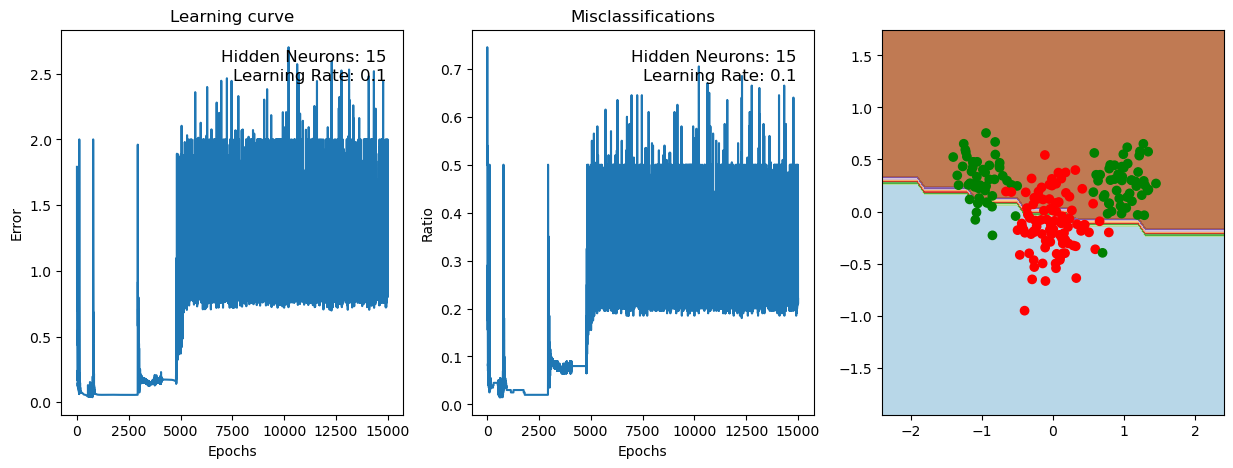

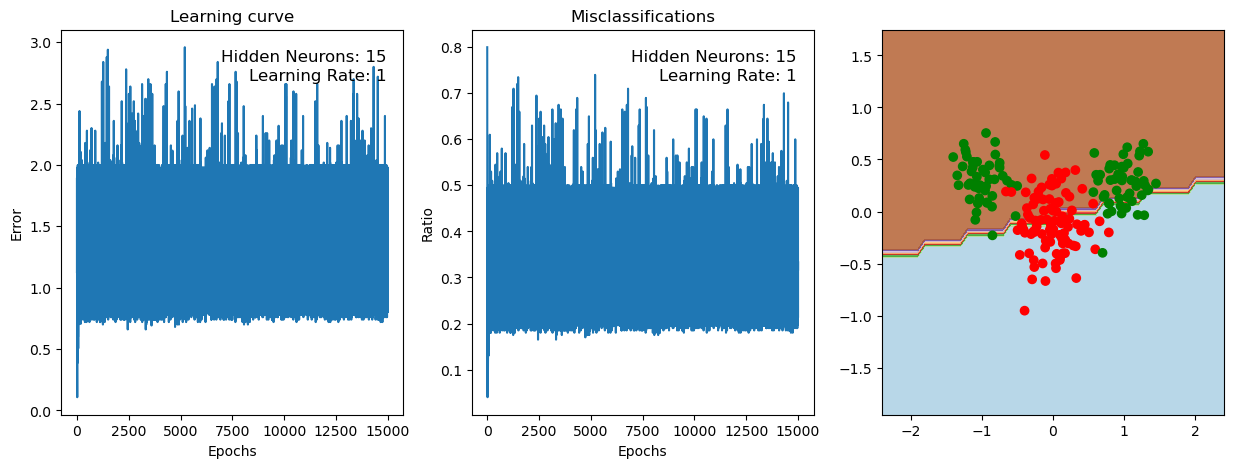

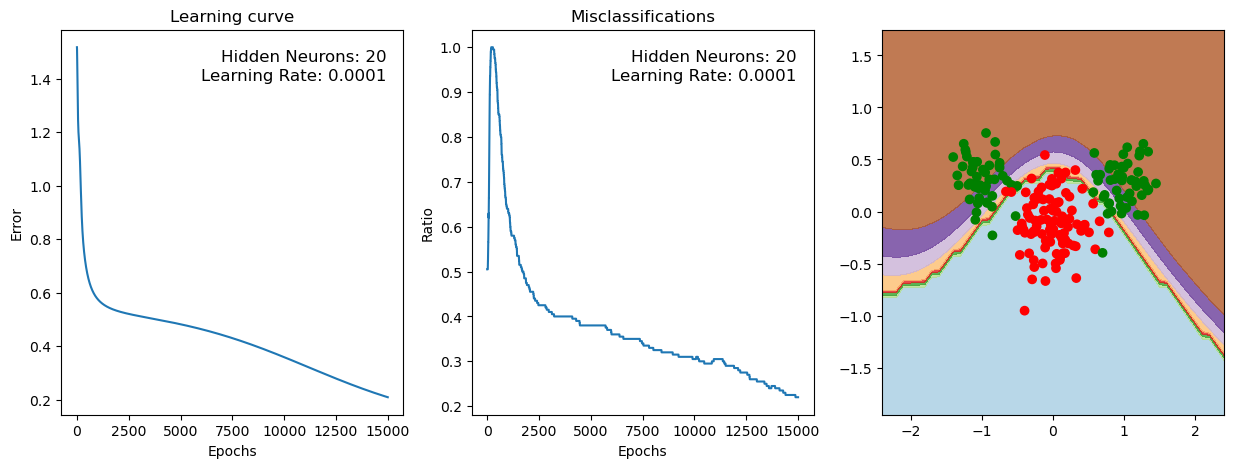

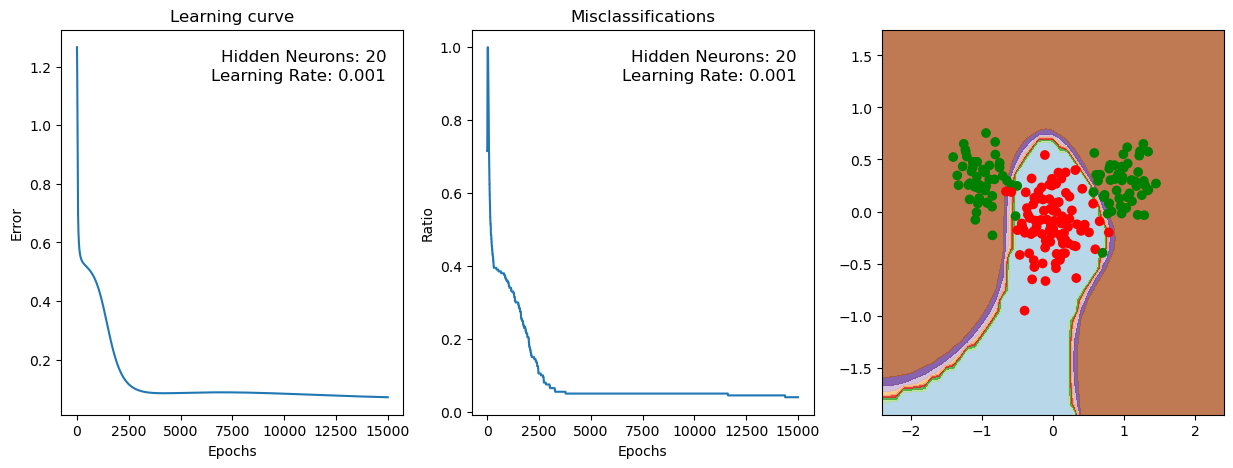

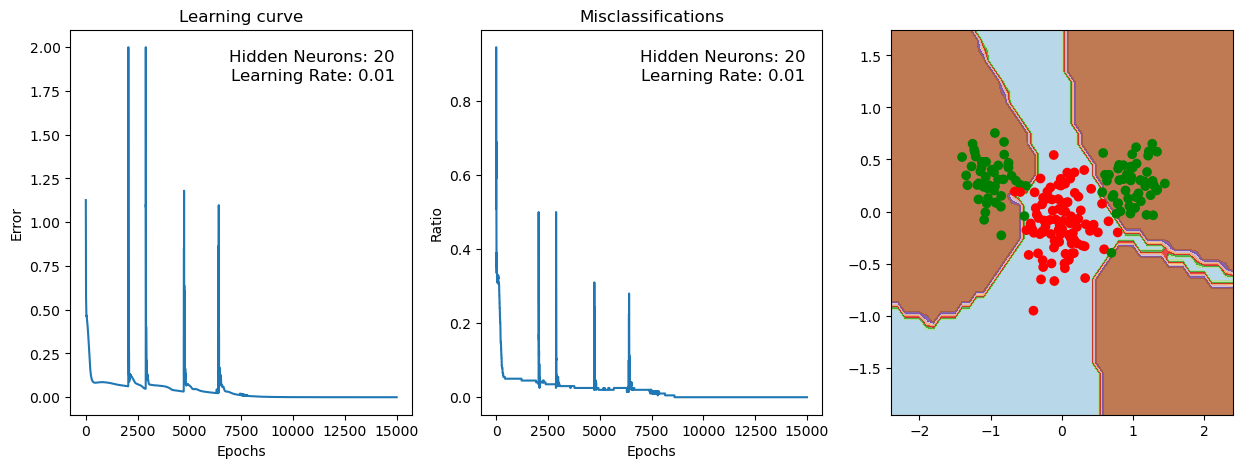

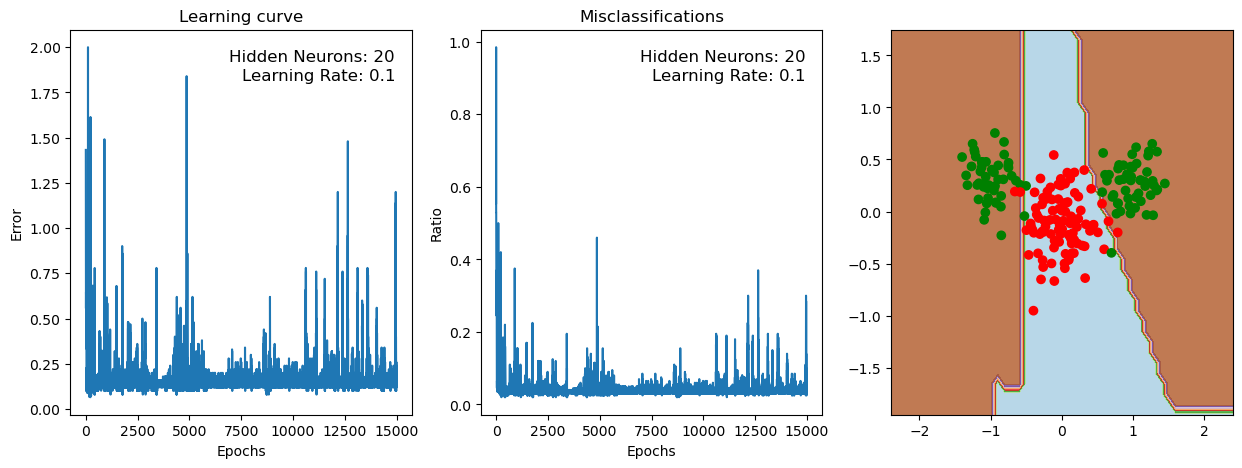

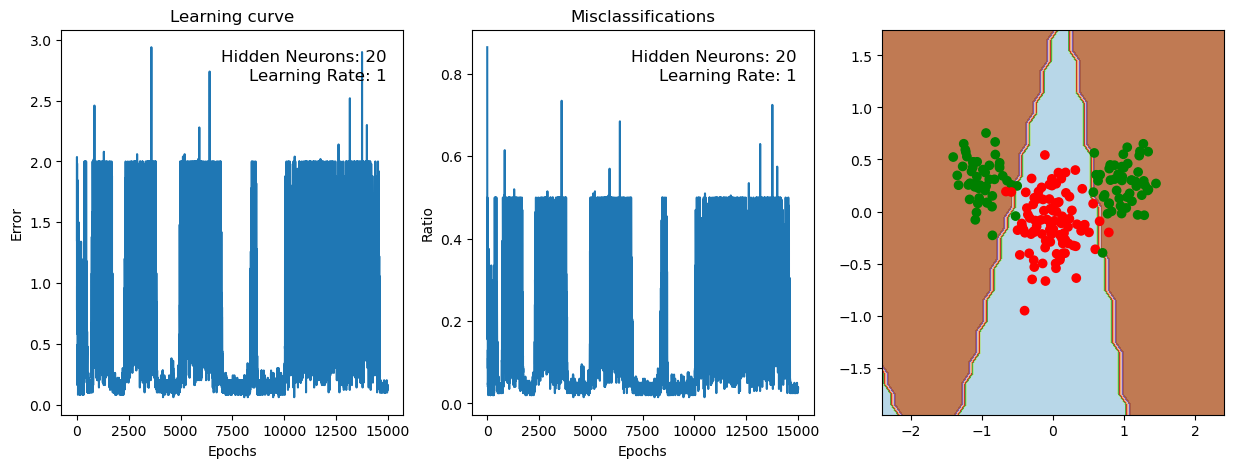

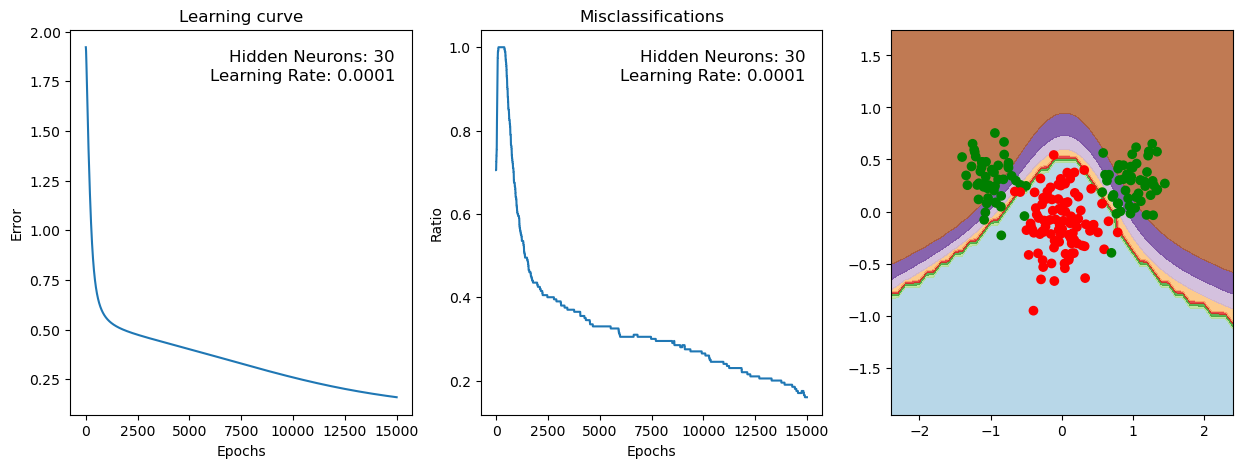

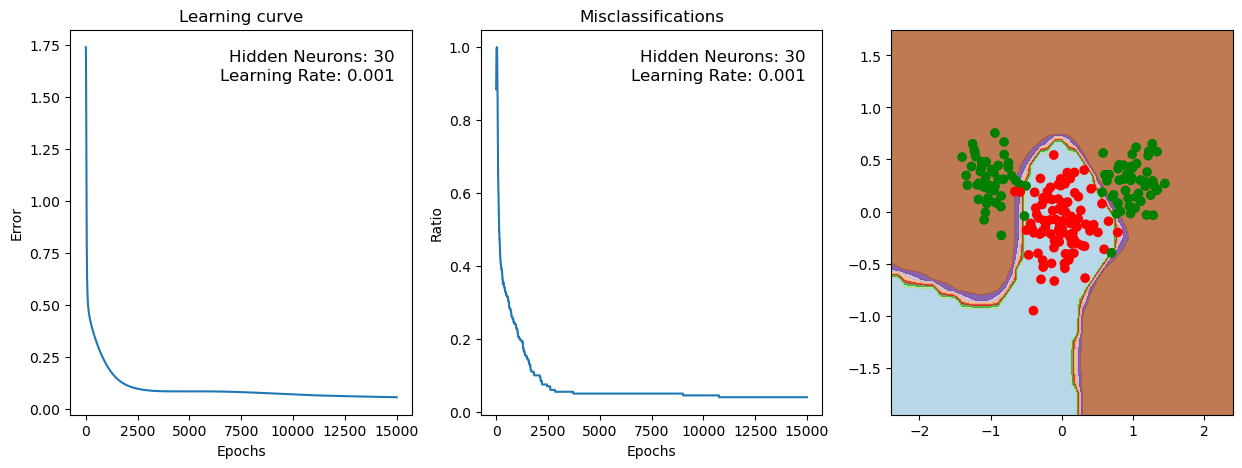

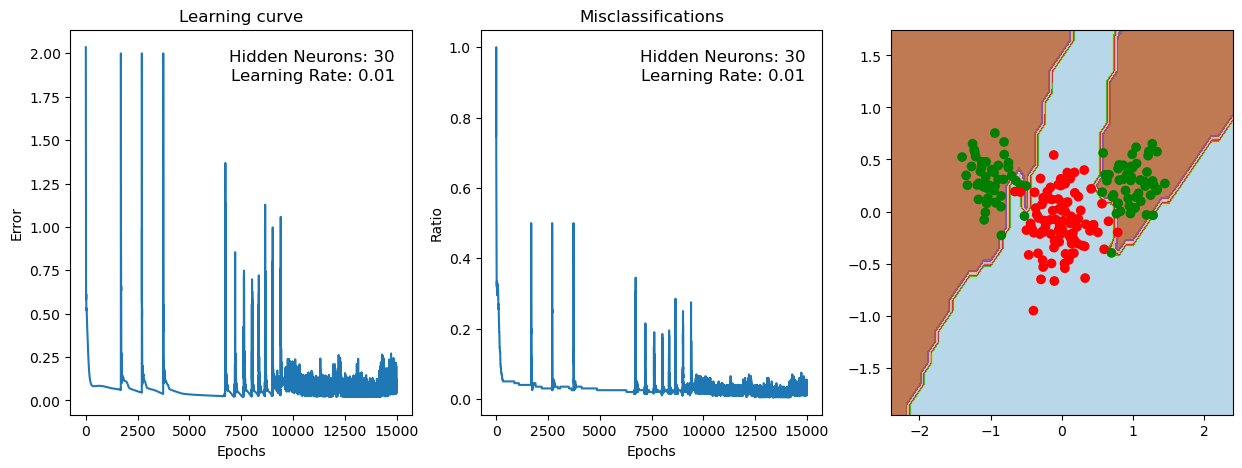

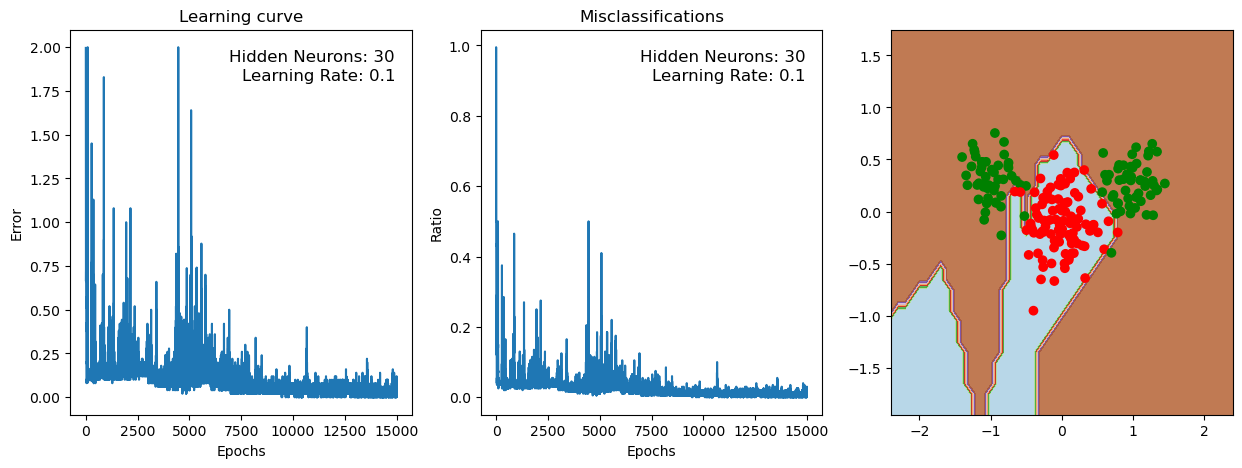

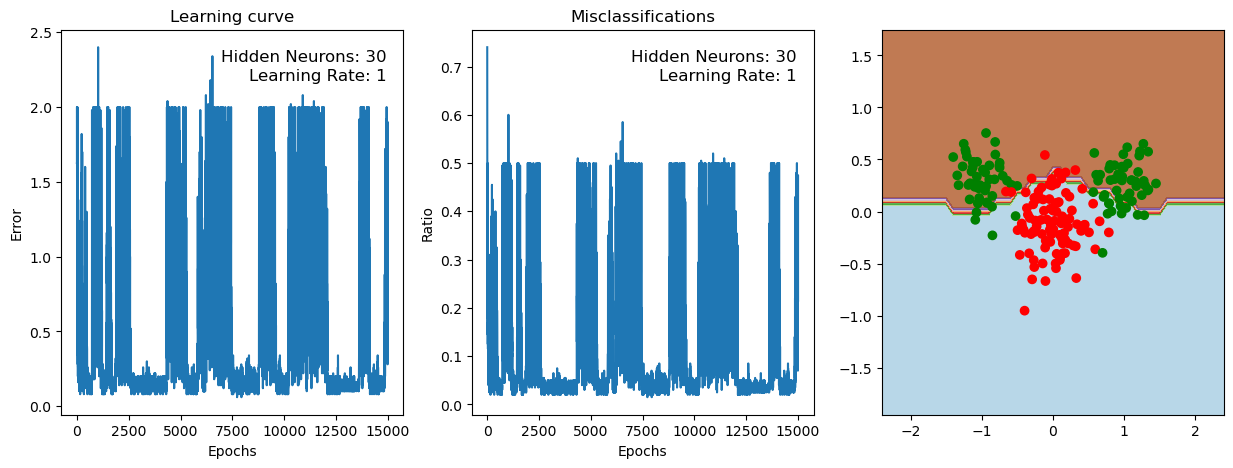

In [21]:
test_hidden_neurons = [1, 5, 10, 15, 20, 30]
test_learning_rates = [0.0001, 0.001, 0.01, 0.1, 1]

for hidden_neurons in test_hidden_neurons:
    for learning_rate in test_learning_rates:
        # Initialize the weights
        weights1 = np.random.randn(hidden_neurons, np.shape(patterns)[0])
        weights2 = np.random.randn(1, hidden_neurons + 1)

        (
            W,
            V,
            errors_list,
            misclassifications_list,
            all_weights1,
            all_weights2,
        ) = backpropagation(
            patterns,
            targets,
            weights1,
            weights2,
            learning_rate,
            epochs,
            hidden_neurons,
            alpha=0.9,
        )

        # Create 1 x 3 subplots. One with the learning curve and one with decision boundary and one with missclassifications
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(errors_list)
        axs[0].set_title("Learning curve")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Error")
        axs[0].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[0].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[0].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[0].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        axs[1].plot(misclassifications_list)
        axs[1].set_title("Misclassifications")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Ratio")
        axs[1].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[1].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[1].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[1].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        axs[2].plot = plot_decision_boundary(patterns, targets, points=True)
        axs[2].set_title("Decision boundary")
        axs[2].set_xlabel("x")
        axs[2].set_ylabel("y")
        axs[2].text(
            0.95,
            0.95,
            f"Hidden Neurons: {hidden_neurons}",
            transform=axs[2].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )
        axs[2].text(
            0.95,
            0.9,
            f"Learning Rate: {learning_rate}",
            transform=axs[2].transAxes,
            fontsize=12,
            ha="right",
            va="top",
        )

        plt.show()